In [1]:
import requests, csv, io, os
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

### Purpose of this Analysis

Analyze Statistics Canada data to determine whether there is a savings gap in Ontario.

This analysis utilizes the recommended retirement replacment ratio of 50-70%, which stipulates the percentage pre-retirement income that needs to be replaced by retirement income via pensions, private savings, and/or government programs to maintain the same standard of living in retirement. 

The savings gap is defined as the difference between thier actual savings/retirement income and this savings/replacement target. 

### Extract Data From Statistics Canada API

Ensure the current working directory correct. Enter the table ID of the table you want to extract, then run the cell below. Ensure you are not on VPN when making this API request because VPN will cause you to get a ConnectionError.

Remove any dashes/dots from the string, only use first 8 digits, if there are more than 8 in the Product ID (PID) number.

In [4]:
# Make sure current directory is here: 
os.chdir('C:\\Users\\SahleEza\\Coding\\BPS_Analysis')

# Save the base URL to a variable
baseurl = 'https://www150.statcan.gc.ca/t1/wds/rest'

# Extract Data from a particular table on StatsCan
tableid = '36100588'
extract_data = '{}/getFullTableDownloadCSV/{}/en'.format(baseurl,tableid)

# Create a session and extract data from URL above 
with requests.Session() as s:
    download = s.get(extract_data)
    # Download content
    decoded_content = download.content.decode('utf-8')
    # Read CSV
    csv_obj = csv.reader(decoded_content.splitlines(), delimiter=',')
    csv_list = list(csv_obj)
    # Print rows 
    for row in csv_list:
        print(row)
        
# Extract the link from the list
zip_list = csv_list[0][1].split('"')
zip_link = zip_list[1]

# Request the zip folder from the URL and extract the files from the zip
r = requests.get(zip_link)
z = ZipFile(io.BytesIO(r.content))
z.extractall(os.getcwd())

# Extract the folder name from zip_link
foldername = zip_link.split('/')[-1]

# Extract the file name from the folder name
filename = foldername.split('-')[0] + '.csv'   
print(foldername,filename)

# Convert CSV into a Pandas DataFrame, data types are floats
data = pd.read_csv(filename, dtype='a')
data.head()

['{"status":"SUCCESS"', 'object:"https://www150.statcan.gc.ca/n1/tbl/csv/36100588-eng.zip"}']
36100588-eng.zip 36100588.csv


,REF_DATE,GEO,DGUID,Statistics,Characteristics,"Income, consumption and savings",UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1999,Canada,2016A000011124,Value,All households,Household disposable income,Dollars,81,millions,6,v116885914,1.1.1.1,546261,NaN,NaN,NaN,0
1,1999,Canada,2016A000011124,Value,All households,Compensation of employees,Dollars,81,millions,6,v116885915,1.1.1.2,506817,NaN,NaN,NaN,0
2,1999,Canada,2016A000011124,Value,All households,Net mixed income,Dollars,81,millions,6,v116885916,1.1.1.3,97809,NaN,NaN,NaN,0
3,1999,Canada,2016A000011124,Value,All households,Property income received,Dollars,81,millions,6,v116885917,1.1.1.4,111791,NaN,NaN,NaN,0
4,1999,Canada,2016A000011124,Value,All households,Less: property income paid,Dollars,81,millions,6,v116885918,1.1.1.5,36406,NaN,NaN,NaN,0


If you cannot access the API with the code above, due to VPN, click on the following link, which will open a new tab within your browser. Copy and paste the link from the new tab into another tab and it should download a zip folder that contains the csv file. 

If you want to download another table, swap out the table ID before '/en' 

https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/36100588/en


Actual StatsCan Table Website: 

https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3610058801

In [7]:
# Import dataframe 
household_data = pd.read_csv('36100588.csv')

# Delete unnecessary columns 
data = household_data.drop(['DGUID','UOM','UOM_ID','SCALAR_ID', 
                     'VECTOR','COORDINATE','STATUS',
                     'SYMBOL','TERMINATED','DECIMALS'], axis=1)

In [8]:
# View all the unique categorical data in each of the following columns 

print('Data', data['Income, consumption and savings'].unique())

print('Households Characteristics', data['Characteristics'].unique())

print('Types of Values', data['Statistics'].unique())

Data ['Household disposable income' 'Compensation of employees'
 'Net mixed income' 'Property income received'
 'Less: property income paid' 'Current transfers received'
 'Less: current transfers paid' 'Social transfers in kind (STiK)'
 'Social transfers in kind (STiK): education'
 'Social transfers in kind (STiK): health'
 'Social transfers in kind (STiK): other'
 'Adjusted household disposable income'
 'Household final consumption expenditure (HFCE)'
 'Food and non-alcoholic beverages' 'Alcoholic beverages and tobacco'
 'Clothing and footwear'
 'Housing, water, electricity, gas and other fuels'
 'Furnishings, household equipment and other goods and services related to the dwelling and property'
 'Health' 'Transport' 'Communications' 'Recreation and culture'
 'Education' 'Food, beverage and accommodation services'
 'Insurance and financial services' 'Miscellaneous goods and services'
 'Household actual final consumption' 'Change in pension entitlements'
 'Household net saving']
Househ

### All Households' Income, Consumption, Savings and Pension Entitlements 

First, let's take a look at the income, consumption, savings, and pensions of all households in Canada compared to Ontario to see if there is a significant discrepancy between Ontario and the rest of the country. 

In [9]:
# Filtering the data for Canadian (All Households') Income, Consumption, Pensions and Savings
canada_income = data[(data['GEO'] == 'Canada')
                        & (data['Income, consumption and savings'] == 'Household disposable income')
                        & (data['Characteristics'] == 'All households')
                        & (data['Statistics'] == 'Value per household')]

canada_consumption = data[(data['GEO'] == 'Canada')
                        & (data['Income, consumption and savings'] == 'Household actual final consumption')
                        & (data['Characteristics'] == 'All households')
                        & (data['Statistics'] == 'Value per household')]

canada_pension = data[(data['GEO'] == 'Canada')
                        & (data['Income, consumption and savings'] == 'Change in pension entitlements')
                        & (data['Characteristics'] == 'All households')
                        & (data['Statistics'] == 'Value per household')]

canada_savings = data[(data['GEO'] == 'Canada')
                        & (data['Income, consumption and savings'] == 'Household net saving')
                        & (data['Characteristics'] == 'All households')
                        & (data['Statistics'] == 'Value per household')]

# Filtering the data for Ontario (All Households') Income, Consumption, Pensions and Savings
ontario_income = data[(data['GEO'] == 'Ontario')
                        & (data['Income, consumption and savings'] == 'Household disposable income')
                        & (data['Characteristics'] == 'All households')
                        & (data['Statistics'] == 'Value per household')]

ontario_consumption = data[(data['GEO'] == 'Ontario')
                        & (data['Income, consumption and savings'] == 'Household actual final consumption')
                        & (data['Characteristics'] == 'All households')
                        & (data['Statistics'] == 'Value per household')]

ontario_pension = data[(data['GEO'] == 'Ontario')
                        & (data['Income, consumption and savings'] == 'Change in pension entitlements')
                        & (data['Characteristics'] == 'All households')
                        & (data['Statistics'] == 'Value per household')]

ontario_savings = data[(data['GEO'] == 'Ontario')
                        & (data['Income, consumption and savings'] == 'Household net saving')
                        & (data['Characteristics'] == 'All households')
                        & (data['Statistics'] == 'Value per household')]


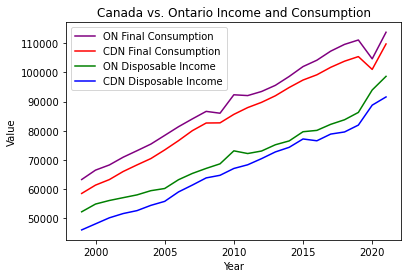

In [10]:
# Plotting Canada vs. Ontario Income and Consumption
plt.plot(ontario_consumption['REF_DATE'], ontario_consumption['VALUE'], color = 'purple', label = 'ON Final Consumption')
plt.plot(canada_consumption['REF_DATE'], canada_consumption['VALUE'], color = 'red', label = 'CDN Final Consumption')
plt.plot(ontario_income['REF_DATE'], ontario_income['VALUE'], color = 'green', label = 'ON Disposable Income')
plt.plot(canada_income['REF_DATE'], canada_income['VALUE'], color = 'blue', label = 'CDN Disposable Income')

plt.title("Canada vs. Ontario Income and Consumption")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()

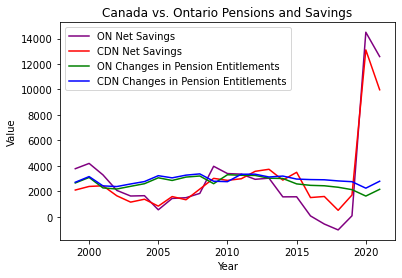

In [11]:
# Plotting Canada vs. Ontario Pensions and Savings 
plt.plot(ontario_savings['REF_DATE'], ontario_savings['VALUE'], color = 'purple', label = 'ON Net Savings')
plt.plot(canada_savings['REF_DATE'], canada_savings['VALUE'], color = 'red', label = 'CDN Net Savings')
plt.plot(ontario_pension['REF_DATE'], ontario_pension['VALUE'], color = 'green', label = 'ON Changes in Pension Entitlements')
plt.plot(canada_pension['REF_DATE'], canada_pension['VALUE'], color = 'blue', label = 'CDN Changes in Pension Entitlements')

plt.title("Canada vs. Ontario Pensions and Savings")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()

### Notes on All Households' Income, Consumption, Savings, and Pensions 

Ontario has a proportionally higher consumption and disposable income than the rest of the country, which has persisted for the last 20 years. Canadians and Ontarians alike have higher consumption levels relative to their disposable income levels. 

There was a spike in savings in 2020, which reflects the increased uncertainty caused by the pandemic.  Whereby pension entitlements seem to be relatively stable over the past 20 years. 

### Retirees (65+ years old)  Income & Replacement Ratio

Next, let's look at households that are above 65 years of age to determine whether their disposable income is similar to the general population. This comparison will also depict whether individuals that are at retirement age are replacing thier income at a ratio that is between 50-70%, which is the recommended rate.  

In [12]:
# Filtering the data for Ontario (65+) Income

ontario65_income = data[(data['GEO'] == 'Ontario')
                        & (data['Income, consumption and savings'] == 'Household disposable income')
                        & (data['Characteristics'] == '65 years and over') 
                        & (data['Statistics'] == 'Value per household')]

canada65_income = data[(data['GEO'] == 'Canada')
                        & (data['Income, consumption and savings'] == 'Household disposable income')
                        & (data['Characteristics'] == '65 years and over')
                        & (data['Statistics'] == 'Value per household')]

# No data exists for Ontario (65+) Consumption, Pensions and Savings

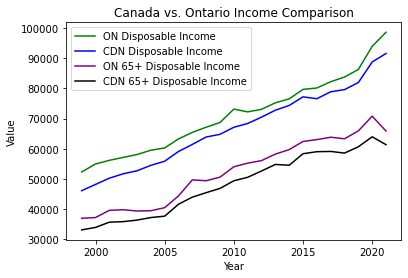

In [40]:
# Plotting Canada vs. Ontario Income and Consumption
plt.plot(ontario_income['REF_DATE'], ontario_income['VALUE'], color = 'green', label = 'ON Disposable Income')
plt.plot(canada_income['REF_DATE'], canada_income['VALUE'], color = 'blue', label = 'CDN Disposable Income')
plt.plot(ontario65_income['REF_DATE'], ontario65_income['VALUE'], color = 'purple', label = 'ON 65+ Disposable Income')
plt.plot(canada65_income['REF_DATE'], canada65_income['VALUE'], color = 'black', label = 'CDN 65+ Disposable Income')

plt.title("Canada vs. Ontario Income Comparison")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()

In [39]:
# Define a function to convert specific columns into lists
def col_to_list(col):
    lst = []
    for i in col:
        lst.append(i)
    return lst

# Convert Ontario 65+ and Ontario All Households into lists
ont65_inc = col_to_list(ontario65_income['VALUE']) 
ont_inc = col_to_list(ontario_income['VALUE'])

# Convert Canada 65+ and Canada All Households into lists
can65_inc = col_to_list(canada65_income['VALUE'])
can_inc = col_to_list(canada_income['VALUE'])

# Calculate the Replacement Ratio for each year
ont_replacement = []
can_replacement = []
for i in range(len(ont65_inc)):
    ont_replacement.append(round(ont65_inc[i] / ont_inc[i],2))
    can_replacement.append(round(can65_inc[i] / can_inc[i],2))

# Determine the Min, Max and Average Replacement Ratio for Ontario and Canada
print('The maximum replacement ratio in Ontario is:', np.array(ont_replacement).max())
print('The minimum replacement ratio in Ontario is:', np.array(ont_replacement).min())
print('The average replacement ratio in Ontario is:', round(np.array(ont_replacement).mean(),2))

print('The maximum replacement ratio in Canada is:', np.array(can_replacement).max())
print('The minimum replacement ratio in Canada is:', np.array(can_replacement).min())
print('The average replacement ratio in Canada is:', round(np.array(can_replacement).mean(),2))


The maximum replacement ratio in Ontario is: 0.79
The minimum replacement ratio in Ontario is: 0.66
The average replacement ratio in Ontario is: 0.73
The maximum replacement ratio in Canada is: 0.77
The minimum replacement ratio in Canada is: 0.67
The average replacement ratio in Canada is: 0.72


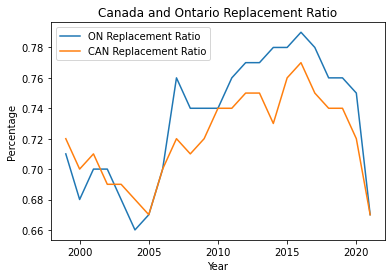

In [35]:
# Plot the Replacement Ratio
plt.plot(ontario_income['REF_DATE'],ont_replacement, label = 'ON Replacement Ratio')
plt.plot(canada_income['REF_DATE'],can_replacement, label = 'CAN Replacement Ratio')
plt.title("Canada and Ontario Replacement Ratio")
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.legend()

### Notes on Retirees' Income and Replacement Ratio

Retirement age households, as expected, have significantly less income than the rest of the general population, despite the fact that not everyone that is retirement age is necessarily retired, the data reflects the drop in income for households that are above the age 65+. 

The replacement ratios for households in Ontario and Canada are 73% and 72% respectively. These ratio are slightly above the recommended 50-70%, which indicates that there is no savings gap. Although these ratios are likely higher than they should be since the data does not clarify whether these households include individuals that are still working after they reach age 65.